In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = np.load("data/30/execute.npz")
ac = data["ac"]
pos = data["pos"]
ori = data["ori"]
w = 0.25

min = 0.0
max = 1.0
step = 0.01

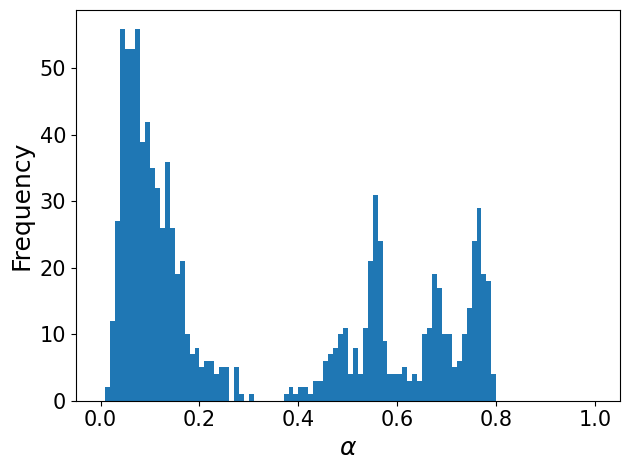

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

n, bins, pathces = ax.hist(ac, bins=np.arange(min, max+step, step=step))
plt.xlabel("$\\alpha$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.tick_params(labelsize=15)
plt.tight_layout()
# fig.show()
plt.savefig("logs/alpha_hist.pdf")

In [54]:
print(n)

print(np.argmax(n==1))

[ 34. 205. 253. 163.  81.  43.  19.  10.  12.  14.  24.  24.  15.   3.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  17.  18.  13.
   4.   9.   2.   8.   2.   9.  10.   7.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
52


In [4]:
def otsu_score(data: np.ndarray, mean: np.ndarray, threshold: float) -> float:
    d0 = data[data<=threshold]
    d1 = data[data>threshold]

    w0 = d0.shape[0] / data.shape[0]
    w1 = d1.shape[0] / data.shape[0]

    if (w0==0) or (w1==0):
        return 0

    mean0 = d0.mean()
    mean1 = d1.mean()
    sigma2_b = w0 * (mean0 - mean)**2 + w1 * (mean1 - mean)**2

    return sigma2_b

def otsu_threshold(data: np.ndarray, step: float, min: float = None, max: float = None) -> float:
    if min is None:
        min = data.min()
    if max is None:
        max = data.max()

    mean = data.mean()

    threshold = min
    max_score = 0
    for thresh in np.arange(min, max+step, step=step):
        score = otsu_score(data, mean, thresh)
        if score > max_score:
            max_score = score
            threshold = thresh

    return threshold

threshold = otsu_threshold(ac, step, min, max)
print(threshold)

0.41000000000000003


In [5]:
def kmeans_threshold(data: np.ndarray) -> float:
    OPTIMIZE_EPSILON = 0.01

    labels = np.random.randint(0, 2, data.shape[0])

    m0_pre = -np.inf
    m1_pre = np.inf

    for _ in range(1000):
        m0 = data[labels == 0].mean()
        m1 = data[labels == 1].mean()

        labels[np.abs(data-m0) < np.abs(data-m1)] = 0
        labels[np.abs(data-m0) >= np.abs(data-m1)] = 1

        if np.abs(m0-m0_pre) < OPTIMIZE_EPSILON and np.abs(m1-m1_pre) < OPTIMIZE_EPSILON:
            break

        m0_pre = m0
        m1_pre = m1

    return np.minimum(data[labels == 0].max(), data[labels == 1].max())

threshold = kmeans_threshold(ac)
print(threshold)

0.4132511595648038


In [6]:
def get_gaus(size: int, sigma: float):
    kernel = np.zeros(size)
    i0 = size // 2
    for i in range(size):
        kernel[i] = np.exp(-(i-i0)**2 / (2*sigma**2))

    kernel /= kernel.sum()

    return kernel

def sezan_threshold(data: np.ndarray, step: float, min: float = None, max: float = None) -> float:
    if min is None:
        min = data.min()
    if max is None:
        max = data.max()

    sigma = 0.5
    size = 20
    gamma = 0.5

    kernel = get_gaus(size, sigma)
    num_hist, range_hist = np.histogram(data, np.arange(min, max+step, step))
    mean_hist = (range_hist[1:] + range_hist[:-1]) / 2

    hist_bar = np.convolve(num_hist, kernel, 'same')
    d_hist = hist_bar[:-1] - hist_bar[1:]
    d_hist = np.r_[[0],d_hist,[0]]

    m = np.where((d_hist[1:] >=0) & (d_hist[:-1] <=0))[0]
    es =np.where((d_hist[1:] <=0) & (d_hist[:-1] >=0))[0]
    m0 = m.min()
    m1 = m.max()
    print(m0, m1)
    # s0 = es[es<m0].max()
    e0 = es[es>m0].min()
    s1 = es[es<m1].max()
    # e1 = es[es>m1].min()
    # print(s0, e0, s1, e1)

    return  (1 - gamma) * mean_hist[e0] + gamma * mean_hist[s1]

threshold = sezan_threshold(ac, step, min, max)
print(threshold)

8 99
0.5549999999999999
